In [19]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [32]:
train_ratio = 0.7
val_ratio = 0.15
# test_ratio = 0.2

# train_ratio = 0.8
# val_ratio = 0.2

no_epochs = 10
batch_size = 64
num_workers = 4

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [23]:
dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True)

dataset_size = len(dataset)
print('Number of images: ', dataset_size)

Number of images:  60000


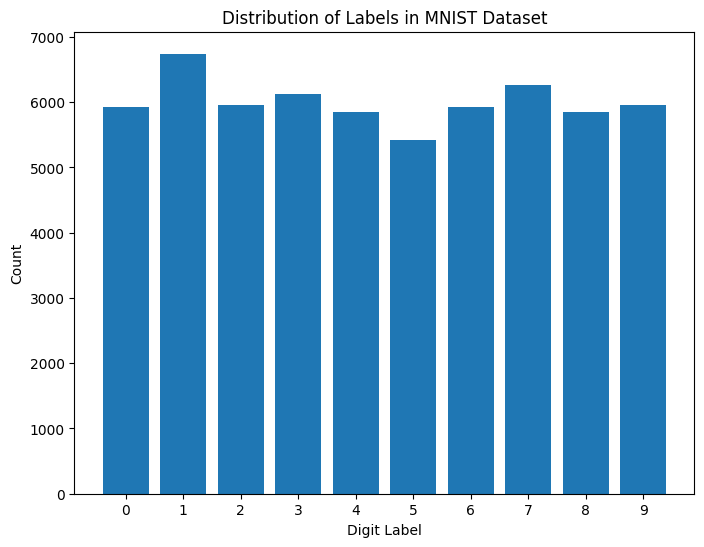

In [24]:
labels = dataset.targets.numpy()
label_counts = np.bincount(labels)

plt.figure(figsize=(8, 6))
plt.bar(range(10), label_counts, tick_label=np.arange(10))
plt.xlabel("Digit Label")
plt.ylabel("Count")
plt.title("Distribution of Labels in MNIST Dataset")
plt.show()

> Class Imbalance

To be reported

In [25]:
samples_per_class = {label: [] for label in range(10)}

for i, (image, label) in enumerate(dataset):
    if len(samples_per_class[label]) < 5:
        samples_per_class[label].append(image)
    if all(len(samples) == 5 for samples in samples_per_class.values()):
        break

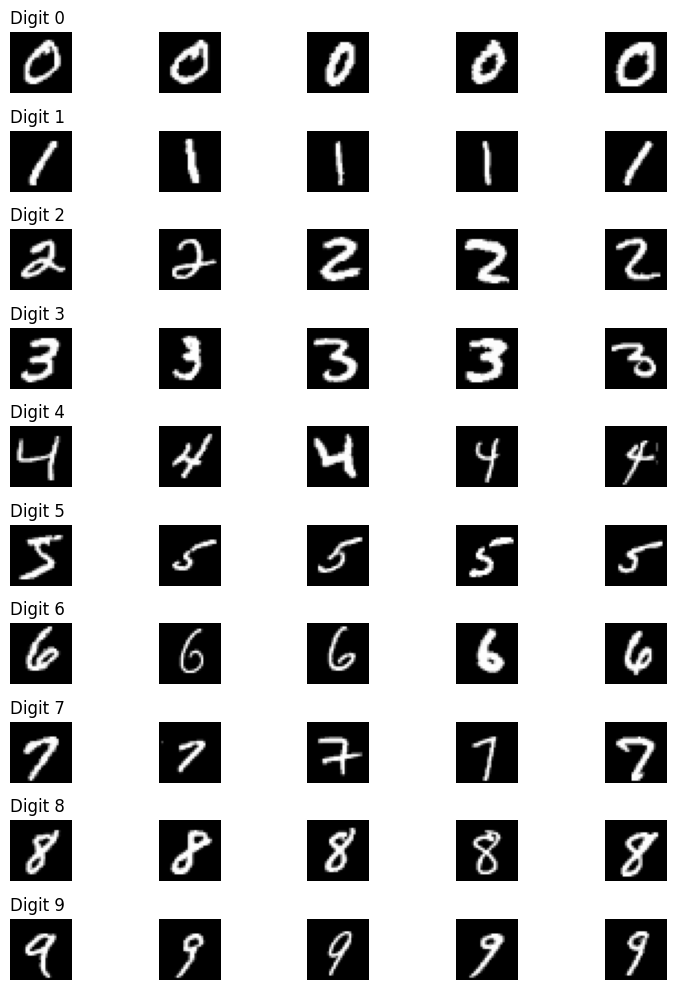

In [26]:
plt.figure(figsize=(8, 10))
for label, samples in samples_per_class.items():
    for i, sample in enumerate(samples):
        plt.subplot(10, 5, label * 5 + i + 1)
        plt.imshow(sample, cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(f'Digit {label}', loc='left')
plt.tight_layout()
plt.show()

In [27]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# To put the data into a DataLoader, we need to convert it into a TensorDataset first

In [33]:
train_set, val_set, test_set = Data.random_split(
    train_dataset, [
        int(train_ratio * dataset_size),
        int(val_ratio * dataset_size),
        int((1 - train_ratio - val_ratio) * dataset_size)
    ]
)

train_loader = Data.DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, num_workers=num_workers)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)
test_loader1 = Data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [29]:
model = BaselineNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
for epoch in range(10):
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")

torch.save(model.state_dict(), "../models/baseline_model_mnist.pth")
print("Saved PyTorch Model State to baseline_model_mnist.pth")

Epoch 1, Batch 100, Loss: 0.852
Epoch 1, Batch 200, Loss: 0.272
Epoch 1, Batch 300, Loss: 0.186
Epoch 1, Batch 400, Loss: 0.165
Epoch 1, Batch 500, Loss: 0.154
Epoch 1, Batch 600, Loss: 0.137
Epoch 2, Batch 100, Loss: 0.125
Epoch 2, Batch 200, Loss: 0.090
Epoch 2, Batch 300, Loss: 0.095
Epoch 2, Batch 400, Loss: 0.091
Epoch 2, Batch 500, Loss: 0.100
Epoch 2, Batch 600, Loss: 0.091
Epoch 3, Batch 100, Loss: 0.076
Epoch 3, Batch 200, Loss: 0.066
Epoch 3, Batch 300, Loss: 0.070
Epoch 3, Batch 400, Loss: 0.081
Epoch 3, Batch 500, Loss: 0.075
Epoch 3, Batch 600, Loss: 0.070
Epoch 4, Batch 100, Loss: 0.064
Epoch 4, Batch 200, Loss: 0.067
Epoch 4, Batch 300, Loss: 0.060
Epoch 4, Batch 400, Loss: 0.051
Epoch 4, Batch 500, Loss: 0.057
Epoch 4, Batch 600, Loss: 0.064
Epoch 5, Batch 100, Loss: 0.043
Epoch 5, Batch 200, Loss: 0.053
Epoch 5, Batch 300, Loss: 0.046
Epoch 5, Batch 400, Loss: 0.052
Epoch 5, Batch 500, Loss: 0.055
Epoch 5, Batch 600, Loss: 0.053
Epoch 6, Batch 100, Loss: 0.045
Epoch 6,

In [31]:
def test(test_loader):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy on the test dataset: {accuracy:.2f}%")

print("On Test Split Set")
test(test_loader)
print("On Test Set")
test(test_loader1)


On Test Split Set
Accuracy on the test dataset: 99.37%
On Test Set
Accuracy on the test dataset: 99.26%


In [34]:
# To check and implement

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_feature_maps(model, layer_name, input_image):
    """
    Visualize feature maps of a trained model for a specific layer.

    Args:
        model (torch.nn.Module): The trained PyTorch model.
        layer_name (str): The name of the layer for which you want to visualize feature maps.
        input_image (torch.Tensor): The input image for which to compute the feature maps.

    Returns:
        None
    """

    # Check if the layer name is valid
    if layer_name not in dict(model.named_children()):
        raise ValueError(f"Layer '{layer_name}' not found in the model.")

    # Get the specified layer
    target_layer = dict(model.named_children())[layer_name]

    # Set the model to evaluation mode
    model.eval()

    # Forward pass to obtain the feature maps
    with torch.no_grad():
        feature_maps = target_layer(input_image.unsqueeze(0))

    # Get the number of feature maps and their dimensions
    num_feature_maps = feature_maps.size(1)
    feature_map_size = feature_maps.size(2)

    # Create a subplot grid for visualization
    num_rows = num_feature_maps // 8 + 1  # Arrange the feature maps in rows of 8
    fig, axes = plt.subplots(num_rows, 8, figsize=(16, 2 * num_rows))

    # Iterate through the feature maps and display them
    for i in range(num_feature_maps):
        row = i // 8
        col = i % 8
        ax = axes[row, col]
        ax.imshow(feature_maps[0, i].cpu(), cmap='viridis')
        ax.axis('off')
        ax.set_title(f"Feature Map {i+1}")

    # Hide any remaining empty subplots
    for i in range(num_feature_maps, num_rows * 8):
        row = i // 8
        col = i % 8
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have a trained model called 'my_model'
# and an input image 'input_image'
# visualize_feature_maps(my_model, 'conv1', input_image)
